# Import

In [1]:
import numpy as np
import scipy.misc as misc
import PIL.ImageDraw
import random
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
import random
import scipy.misc
import tensorflow as tf
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Functions

In [64]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM



import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    # print(cos_sims,"================================================================================================")
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        # print(dist, '************************************************************************************************')
        if dist>1:
            failed+=1
    return failed/len(data)

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq

    SOMs = []
    QEs= []
    TEs=[]

    for epoch in np.arange(0, epochs):
        train_data_subset = random.sample(train_data, k=5000)
        for train_ex in train_data_subset:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                    learn_rate, radius_sq, (g,h))
        SOMs.append(SOM)

        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)

        train_data_subset02 = random.sample(train_data, k=3000)
        QE = round(calculateQE(SOM, train_data_subset02), 4)
        TE = round(calculateTE(SOM, train_data_subset02), 4)
        print('epoch:',epoch,
              'QE',QE,
              'TE',TE,
              'SOM', SOM[0][0],
              )
        QEs.append(QE)
        TEs.append(TE)

    return SOMs, QEs, TEs

import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):

    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    # normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([p], [c])[0][0] for c in r] for r in SOM])
    # normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

# Import Text

In [5]:
with open('paragraphs.obj', 'rb') as pickleFile:
    paragraphs = pickle. load(pickleFile)

with open('preprocessed2.obj', 'rb') as pickleFile:
    preprocessed2 = pickle. load(pickleFile)

In [ ]:
paragraphs_list = [entry['paragraph'] for entry in paragraphs]

# Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
with open('trained_model.obj', 'rb') as pickleFile:
  model = pickle. load(pickleFile)

In [6]:
  # with open('vectors_TAL_AllSentences.obj', 'wb') as f:
  #   pickle.dump(vectors, f)

with open('vectors_TAL_AllSentences.obj', 'rb') as pickleFile:
    vectors = pickle. load(pickleFile)

In [ ]:
len(vectors)


1575820

# SOM

In [81]:
# Initialize SOM grid dimensions
m = 50
n = 50

# Initialize training data
train_data = vectors[:50000]

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

SOMs, QE, TE = train_SOM(SOM, train_data, learn_rate=0.1, radius_sq=12, epochs=50)

True
True
True
epoch: 0 QE 0.6141 TE 0.297 SOM [0.71219916 0.11435252 0.49388815 0.76882328 0.88378352 0.16804488
 0.06952565 0.69591616 0.8031873  0.36823823 0.04984293 0.76388891
 0.60648671 0.95598416 0.17029406 0.5066606  0.49844345 0.7407004
 0.4844765  0.53863833 0.56801704 0.49155207 0.37530804 0.96495618
 0.89029134 0.96532803 0.59252311 0.32777993 0.16005618 0.76895018
 0.23663571 0.16504223 0.9708828  0.17844066 0.13111517 0.71851975
 0.5928174  0.80079439 0.71451605 0.19754071 0.1345387  0.98828809
 0.80362943 0.50239574 0.41433914 0.3343812  0.98803862 0.0279486
 0.60249479 0.92251791 0.58366301 0.78910973 0.54265811 0.60889885
 0.64577127 0.04147544 0.02901708 0.03399314 0.39690783 0.97492328
 0.2984863  0.89464005 0.88299344 0.49983163 0.39622319 0.38354051
 0.7235698  0.4911678  0.60905581 0.13700973 0.96726213 0.48273941
 0.19620665 0.87491287 0.21343606 0.15172542 0.66057512 0.60737111
 0.34301539 0.76101453 0.75929345 0.63320307 0.73144954 0.56903146
 0.00137377 0.341

In [88]:
print(SOMs[0][0][0][0])
print(SOMs[15][0][0][0])

-0.006224339011290566
-0.006224339011290566


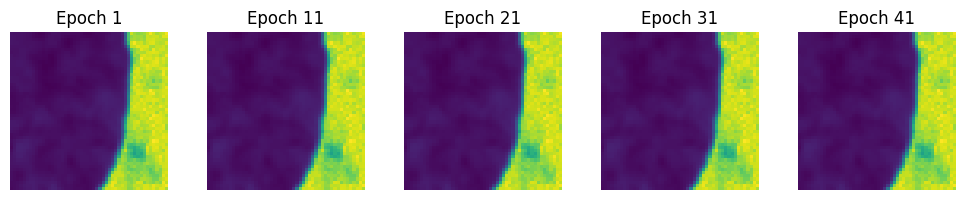

In [87]:
def plot_SOM_epochs(SOMs):
    num_epochs = len(SOMs)
    fig, axes = plt.subplots(nrows=1, ncols=num_epochs // 10, figsize=(2 * (num_epochs // 10), 2))
    for i in range(0, num_epochs, 10):
        ax = axes[i // 10]
        # Compute the mean of vectors within each cell of the SOM
        SOM_image = np.mean(SOMs[i], axis=2)  # You might adjust axis according to your data structure
        ax.imshow(SOM_image, cmap='viridis')
        ax.set_title(f'Epoch {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_SOM_epochs(SOMs)

# Save/Import Trained SOM

In [ ]:
# with open('xxx.obj', 'wb') as f:
#   pickle.dump(SOM, f)

# with open('xxx.obj', 'rb') as pickleFile:
#   SOM = pickle. load(pickleFile)

# U-Matrix

In [ ]:
u_matrix_values = u_matrix(SOM)

In [ ]:
plt.figure(figsize=(15, 15))
colors = [(0, "#5E8068"), (.5, "#CAC1BC"), (1, "#ED5667")] # "#ED5667"), (.5, "#CAC1BC"), (1, "#5E8068",,,, (0, "#5673ed"), (.5, "#bdb9ca"), (1, "#80655e")
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Initialize an empty dictionary to store sentences associated with each neuron
neuron_sentence_mapping = {(i, j): [] for i in range(SOM.shape[0]) for j in range(SOM.shape[1])}

In [ ]:
# Iterate through each sentence and find its BMU, then append it to the corresponding neuron's list
for idx, sentence in enumerate(paragraphs_list):
    vector = vectors[idx]
    bmu = find_BMU(SOM, vector)
    neuron_sentence_mapping[bmu].append(sentence)

In [1]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(50, 50))
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
# plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 3
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:200]  # Take the first 100 characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

plt.savefig('SOM_Text.pdf', format='pdf')

# Show the plot
plt.show()

# Activate The SOM: Sentence

In [ ]:
# Step 1: Convert the query sentences into vectors
query_sentences = ["the house"]
query_vectors = [model.infer_vector(word_tokenize(sentence.lower())) for sentence in query_sentences]

In [2]:
# Step 2: Activate the SOM using the activate function for each query vector
activated_SOMs = []
for query_vector in query_vectors:
    activated_SOM = activate(train_data, SOM, query_vector)
    activated_SOMs.append(activated_SOM)

# Step 2: Activate the SOM using the activate function
activated_SOM = activate(train_data, SOM, query_vector)

In [3]:
# Step 3: Plot the U-matrix for each activated SOM
plt.figure(figsize=(15, 15))
for i, activated_SOM in enumerate(activated_SOMs):
    plt.subplot(1, len(activated_SOMs), i+1)
    colors = [(0, "#5E8068"), (.5, "#CAC1BC"), (1, "#ED5667")]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
    im = plt.imshow(activated_SOM, cmap=cmap, aspect='auto')
    plt.title(f'U-Matrix for Query Sentence {i+1}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])

plt.show()